## Libraries

In [2]:
%load_ext autoreload
%autoreload 2.0
%matplotlib inline

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-pack

In [4]:
import glob
# import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import sys
sys.path.insert(0, '../.')
from data.segmentation_dataset_loader import *
from data.detection_dataset_loader import *
from model import *
from evaluation.evaluate import *
from data.postprocessing.nms import *
from data.data_utils.reader_utils import *

In [5]:
tf.__version__

'1.14.0'

## Utils

In [112]:
def sigmoid(x):
    x = x.astype(np.float128)
    x = 1 / (1 + np.exp(-x))
    x = x.astype(np.float32)
    return x

def convert_prediction_into_real_values(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(448, 512), output_size=(112, 128), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    ratio = 1
    result = []
    ones_index = np.where(sigmoid(label_tensor[:, :,  -1])>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, -1]>=th)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
            
#             print('x = ', x, "y = ", y)
            
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], :])
            anchor = np.array([x+0.5, y+0.5, 0.5, anchors[0], anchors[1], anchors[2]])

#             mins = np.array([-0.5, -0.5, 0, 0.7, 0.1, 0.1, -1.1, -1.1])
#             maxs = np.array([0.5, 0.5, 1, 1.9, 0.75, 0.91, 1.1, 1.1])
        
#             out[:8] = ((out[:8] + 1) / 2) * (maxs - mins) + mins
#             out[:2] = out[:2][::-1]
#             if truth_value is not None:
#                 print('gt = ', truth_value[ones_index[0][i], ones_index[1][i], :3])
#             print('out[:3] = ', out[:3])
            out[:3] = np.exp(out[:3])
#             print('exp(out[:3]) = ', out[:3])
    
            out[:3] = out[:3] + anchor[:3]
#             print('out[:3] anch = ', out[:3])
            
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 35
            
#             print('final out[:3] = ', out[:3])
            
            
            
#             out[6] = np.arctan2(out[6], out[7])
                        
            result.append(out)
            
    return np.array(result)

In [7]:
import numpy as np
from PIL import Image, ImageDraw
import math
import numpy.matlib as npm

def convert5Pointto8Point(cx_, cy_, w_, h_, a_):

    theta = math.radians(a_)
    bbox = npm.repmat([[cx_], [cy_]], 1, 5) + \
       np.matmul([[math.cos(theta), math.sin(theta)],
                  [-math.sin(theta), math.cos(theta)]],
                 [[-w_ / 2, w_/ 2, w_ / 2, -w_ / 2, w_ / 2 + 8],
                  [-h_ / 2, -h_ / 2, h_ / 2, h_ / 2, 0]])
    x1, y1 = bbox[0][0], bbox[1][0]
    x2, y2 = bbox[0][1], bbox[1][1]
    x3, y3 = bbox[0][2], bbox[1][2]
    x4, y4 = bbox[0][3], bbox[1][3]

    return [x1, y1, x2, y2, x3, y3, x4, y4]

In [8]:
def get_points(converted_points, calib_path, 
                x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                size=(448, 512, 35), th=0.5):
    all_result = []
    for converted_points_ in converted_points:
        if sigmoid(converted_points_[-1]) >= th:
            result = [0] * 16
            result[0] = 'Car'
            result[1] = -1
            result[2] = -1
            result[3] = -10
            result[8] = converted_points_[5]
            result[9] = converted_points_[4]
            result[10] = converted_points_[3]
            result[14] = np.arctan2(converted_points_[6], converted_points_[7])
            result[15] = sigmoid(converted_points_[-1])

            calib_data = read_calib(calib_path)

            x_size = (x_range[1] - x_range[0])
            y_size = (y_range[1] - y_range[0])
            z_size = (z_range[1] - z_range[0])

            x_fac = (size[0]-1) / x_size
            y_fac = (size[1]-1) / y_size
            z_fac = (size[2]-1) / z_size          

#             print(converted_points_[:3])
#             converted_points_[0] = 179.55859811597736
#             converted_points_[1] = 276.6431893013815
#             , 206.281385562958]
#             print(converted_points_[:3])
            x, y, z = -((converted_points_[:3] - size) / np.array([x_fac, y_fac, z_fac])) - np.array([0, -1*y_range[0], -1*z_range[0]]) 
            point = np.array([[x, y, z]])
#             print('point')
#             print(point)
            box3d_pts_3d = point

            pts_3d_ref = project_velo_to_ref(box3d_pts_3d, calib_data['Tr_velo_to_cam'].reshape((3, 4)))
#             print('pts_3d_ref')
#             print(pts_3d_ref)
            pts_3d_ref = project_ref_to_rect(pts_3d_ref, calib_data['R0_rect'].reshape((3, 3)))[0]
#             print('pts_3d_ref')
#             print(pts_3d_ref)
            for k in range(3):
                result[11 + k] = pts_3d_ref[k]

            imgbbox = ProjectTo2Dbbox(pts_3d_ref, converted_points_[5], converted_points_[4],
                         converted_points_[3], converted_points_[6], calib_data['P2'].reshape((3, 4)))

            result[4:8] = imgbbox
            all_result.append(result)
    return all_result

## Evaluation

In [9]:
def read_label(rot, tr, sc, label_path, calib_path, shift_h, shift_w, x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                    size=(448, 512, 35), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, translate_z=0, ang=0, get_neg=False, fliplr=False):

    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path) as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    if len(lines) > 0:
        if get_neg:
            # lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            # lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car', 'Van', 'Truck', 'Tram']), lines))
             lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car']), lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = np.array(get_parameter(0))
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    directions = np.array(angles>= 0).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    # print(locations.shape)
    # print(locations)
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo2(rot, tr, sc, locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    # if len(locations) > 0 and len(locations[0]) > 0:
    #     locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    # print(locations.shape)
    # print(z_range)
    # print(locations)

    indx = []
    i = 0
    for point in locations:
        if (point[0] >= x_range[0]  and point[0] <= x_range[1])\
            and (point[1] >= y_range[0] and point[1] <= y_range[1])\
            and (point[2] >= z_range[0] and point[2] <= z_range[1]):
            indx.append(i)
        i += 1

    
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))
    
    if len(indx) > 0:
        dimension_height = dimension_height[indx]
        dimension_width = dimension_width[indx]
        dimension_length = dimension_length[indx]
        location_x = location_x[indx]
        location_y = location_y[indx]
        location_z = location_z[indx]
        angles = angles[indx]
        classes = classes[indx]
        directions = directions[indx]

    points = [project_point_from_camera_coor_to_velo_coor2(rot, tr, sc, [location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    # points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
    #                                                     [dimension_height[i], dimension_width[i], dimension_length[i]],
    #                                                     angles[i],
    #                                                      calib_data)
    #             for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size

    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 35) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 35) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 35) * y_fac + size[1]
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)

      
#     for i in range(len(locations)):
#         if angles[i] < 0:
#             angles[i] += 3.14

    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)
    output = [[-(locations[i][0] + -1*x_range[0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
                for i in range(len(locations))]
    # output = [[locations[i][0], locations[i][1], locations[i][2], 
    #             dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
    #             for i in range(len(locations))]
    # import math
    if fliplr:
        for i in range(len(locations)):
            h = size[1]
            output[i][1] = h - output[i][1]

    if ang != 0:
        for i in range(len(locations)):
            # w = size[0]
            # h = size[1]
            # output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = list(filter(lambda point: 0 <= point[0] < size[0] and 0 <= point[1] < size[1] and 0 <= point[2] < size[2] , output))
    output = np.array(output)

    return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2'], directions


In [10]:
def read_label2(label_path, calib_path, shift_h, shift_w, x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                    size=(448, 512, 35), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, translate_z=0, ang=0, get_neg=False):

    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path, 'r') as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car']), lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = np.array(get_parameter(0))
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    # print(locations)
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    # print(locations)
    # print(z_range)
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

    indx = []
    i = 0
    for point in locations:
        if (point[0] >= x_range[0]  and point[0] <= x_range[1])\
            and (point[1] >= y_range[0] and point[1] <= y_range[1])\
            and (point[2] >= z_range[0] and point[2] <= z_range[1]):
            indx.append(i)
        i += 1

    if len(indx) > 0:
        dimension_height = dimension_height[indx]
        dimension_width = dimension_width[indx]
        dimension_length = dimension_length[indx]
        location_x = location_x[indx]
        location_y = location_y[indx]
        location_z = location_z[indx]
        angles = angles[indx]
        classes = classes[indx]

    if len(locations) > 0:
        locations[:, :3] = locations[:, :3] - np.array([translate_x, translate_y, -translate_z])

    # print('.......')
    # print(len(locations))

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 35) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 35) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 35) * y_fac + size[1]
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)

      
#     for i in range(len(locations)):
#             if angles[i] < 0:
#                 angles[i] += np.pi

    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)
    output = [[-(locations[i][0] + -1*x_range[0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_height[i], dimension_width[i], dimension_length[i], angles[i]] 
                for i in range(len(locations))]
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = list(filter(lambda point: 0 <= point[0] < size[0] and 0 <= point[1] < size[1] and 0 <= point[2] < size[2] , output))
    output = np.array(output)

    return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2']




In [11]:
base_path = '../../../Data'

In [130]:
def get_augmentation_parameters(augment):
        # if self.augment:
        if augment:

                    if np.random.random_sample() >= 0.0:
                        image_translate_x = random.randint(-50, 50)
                    else:
                        image_translate_x = 0
                    if np.random.random_sample() >= 0.0:
                        image_translate_y = random.randint(-25, 25)
                    else:
                        image_translate_y = 0

                    if np.random.random_sample() >= 0.0:
                        translate_x = np.random.random_sample() * 20 - 10
                    else:
                        translate_x = 0
                    if np.random.random_sample() >= 0.0:
                        # translate_y = random.randint(-15, 15)
                        translate_y = np.random.random_sample() * 20 - 10
                    else:
                        translate_y = 0

                    if np.random.random_sample() >= 0.0:
                        translate_z = random.random() - 0.5
                    else:
                        translate_z = 0

                    if np.random.random_sample() >= 0.0:
                        ang = np.random.random_sample() * 90 - 45
                    else:
                        ang = 0

                    r = R.from_rotvec(np.radians(ang) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = translate_x
                    tr_y = translate_y
                    tr_z = translate_z
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
                    
                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    
                    sc_x = 1
                    sc_y = 1
                    sc_z = 1   

#                     if np.random.random_sample() >= 0.0:
#                        sc_x += ((random.random() * 2) - 1.) / 10.

#                     if np.random.random_sample() >= 0.0:
#                        sc_y  += ((random.random() * 2) - 1.) / 10.
                    

                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

                    fliplr = np.random.random_sample() >= 0.5

        else:
                    image_translate_x = 0
                    image_translate_y = 0

                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    ang = 0

                    r = R.from_rotvec(np.radians(0) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = 0
                    tr_y = 0
                    tr_z = 0
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])

                    sc_x = 1
                    sc_y = 1
                    sc_z = 1
                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

                    fliplr = False

        return rot, tr, sc, image_translate_x, image_translate_y, ang, fliplr

In [131]:
def data_generator(base_path, i, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths, 
                   image_size=(370, 1224), lidar_size=(700, 800, 35), anchors=np.array([3.9, 1.6, 1.5]),
                        augment_translate=False, augment_rotate=False):

                rot, tr, sc, image_translate_x, image_translate_y, ang, fliplr = get_augmentation_parameters(False)

                data_reader_obj = DataReader(list_camera_paths[i],
                             list_calib_paths[i], 
                             list_label_paths[i], 
                             list_lidar_paths[i], 
                             rot, sc, tr, ang, image_translate_x, image_translate_y, get_actual_dims=False, fliplr=fliplr)
                camera_image = data_reader_obj.read_image()
                lidar_image = data_reader_obj.lidar_reader.read_lidar()
                _, label, directions = data_reader_obj.label_reader.read_label()
            
                label = get_target(label, directions, anchors=anchors)
              
                yield(camera_image, lidar_image, label)

In [14]:
params = {
    'fusion': False
}
model = Model(graph=None, **params)

/home/injy/mariam_workspace/env/lib/python3.5/site-packages/torch/hub.py:411: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where











In [15]:
def read_label2(label_path, calib_path, shift_h, shift_w, x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                    size=(448, 512, 35), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, ang=0, get_neg=False):
#     return __read_label(label_path, calib_path, shift_h, shift_w, x_range=x_range, y_range=y_range, z_range=z_range, 
#                     size=size, get_actual_dims=get_actual_dims, from_file=from_file, translate_x=translate_x, translate_y=translate_y, ang=ang, get_neg=get_neg)



# def __read_label(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
#                     size=(512, 448, 32), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, ang=0,
#                     get_neg=False):
    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path) as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
#     print('lines', len(lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car']), lines))
#             print(len(lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = get_parameter(0)
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
#     print('locations', len(locations))
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
#     print('locations', len(locations))
    # print(z_range)
    indxes = np.array(list(map(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))
#     print("indxes", len(indxes[indxes==True]))
#     print("indxes", indxes)
#     print(locations)
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

#     print(locations)
#     print('locations', len(locations))
    if len(locations) > 0:
        locations[:, :2] = locations[:, :2] - np.array([translate_x, translate_y])

    # print('.......')
    

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 35) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 35) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 35) * y_fac + size[1]
            # print(dimension_length[i])
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            # print(dimension_length[i])
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            # print(dimension_height[i])
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)
            # print(dimension_height[i])

      


    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    output = [[-(locations[i][0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
                for i in range(len(locations))]
    
#     for i in range(len(locations)):
#             if angles[i] < 0:
#                 angles[i] += np.pi
        
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = np.array(output)
    if from_file:
        return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2']
    else:
        return output, indxes




In [16]:
def prepare_dataset_feed_dict_2(model, dataset, train_fusion_rgb, is_training=False):
        data = list(next(dataset))

        for i in range(len(data)):
            data[i] = np.expand_dims(data[i], axis=0)
        camera_tensor, lidar_tensor, label_tensor = data
        d = {model.train_inputs_rgb: camera_tensor,
                model.train_inputs_lidar: lidar_tensor,
                model.y_true: label_tensor,
                model.train_fusion_rgb: train_fusion_rgb,
                model.is_training: False}
        return d

In [17]:
training=False

In [18]:
if training:
                file_name = '/trainsplit.txt'
else:
                file_name = '/valsplit.txt'
with open(base_path + file_name, 'r') as f:
                list_file_nums = f.readlines()
list_files = ['0'*(6-len(l.strip())) + l.strip() for l in list_file_nums]

list_camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
list_lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
list_label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
list_calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))

In [19]:
i_c = 5
current_file = list_files[i_c]
current_file

'000008'

In [20]:
t = base_path + '/data_object_label_2/training/label_2/'+ current_file + '.txt'
!cat $t

Car 0.88 3 -0.69 0.00 192.37 402.31 374.00 1.60 1.57 3.23 -2.70 1.74 3.68 -1.29
Car 0.00 1 2.04 334.85 178.94 624.50 372.04 1.57 1.50 3.68 -1.17 1.65 7.86 1.90
Car 0.34 3 -1.84 937.29 197.39 1241.00 374.00 1.39 1.44 3.08 3.81 1.64 6.15 -1.31
Car 0.00 1 -1.33 597.59 176.18 720.90 261.14 1.47 1.60 3.66 1.07 1.55 14.44 -1.25
Car 0.00 0 1.74 741.18 168.83 792.25 208.43 1.70 1.63 4.08 7.24 1.55 33.20 1.95
Car 0.00 0 -1.65 884.52 178.31 956.41 240.18 1.59 1.59 2.47 8.48 1.75 19.96 -1.25
DontCare -1 -1 -10 800.38 163.67 825.45 184.07 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 859.58 172.34 886.26 194.51 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 801.81 163.96 825.20 183.59 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 826.87 162.28 845.84 178.86 -1 -1 -1 -1000 -1000 -1000 -10


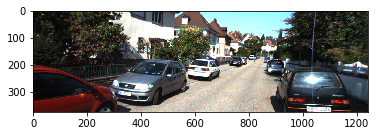

In [21]:
img = mpimg.imread(base_path + '/data_object_image_3/training/image_3/' +current_file+".png")
plt.imshow(img)

In [141]:
with model.graph.as_default():
    
            
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True

  with tf.Session(config=config) as sess:
#     model.saver.restore(sess, tf.train.latest_checkpoint('../training_files_archive/training_files/tmp/'))
    model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp/'))
#     model.saver.restore(sess, tf.train.latest_checkpoint('../training_files_archive/training_files/tmp/'))
#     model.saver.restore(sess, tf.train.latest_checkpoint('../training_files_to_resume/tmp/'))
#     model.saver.restore(sess, tf.train.latest_checkpoint('../training_files_archive/training_files_3/tmp/'))
    dataset = data_generator(base_path, i_c, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths)
   
    i = 0
    if True:

      feed_dict = prepare_dataset_feed_dict_2(model, dataset, False)
      feed_dict[model.weight_cls] = 1
      feed_dict[model.weight_loc] = 1
      feed_dict[model.weight_dim] = 1
      feed_dict[model.weight_theta] = 1
   

      final_output, cls_loss, loc_loss, dim_loss, theta_loss,\
                        reg_loss, iou, iou_2d, iou_dim, iou_loc,\
                        precision, recall, theta_accuracy,\
                    debug_layers, cnn_lidar_resgroups= sess.run([model.final_output,\
                                                              model.classification_loss, model.loc_reg_loss, model.dim_reg_loss, model.theta_reg_loss,\
                                                              model.regression_loss,\
                                                             model.iou, model.iou_2d, model.iou_dim, model.iou_loc,\
                                                             model.precision, model.recall,\
                                                              model.theta_accuracy, model.debug_layers, model.cnn_lidar.res_groups2 ],\
                                                             feed_dict=feed_dict) 

INFO:tensorflow:Restoring parameters from ../training_files/tmp/model.ckpt-1841


In [71]:
cls_loss, loc_loss, dim_loss, theta_loss, theta_accuracy, reg_loss, iou, iou_2d, iou_dim, iou_loc, precision, recall

(1.5908554,
 0.11739168,
 0.020437919,
 0.32346642,
 59.34203,
 1.7017624,
 0.5656975,
 0.6471665,
 0.7738417,
 0.5689702,
 1.0,
 0.33333334)

In [142]:
cls_loss, loc_loss, dim_loss, theta_loss, theta_accuracy, reg_loss, iou, iou_2d, iou_dim, iou_loc, precision, recall

(6.8479066,
 0.16500121,
 0.0915212,
 0.5066709,
 118.4841,
 3.0718951,
 0.4502249,
 0.49062923,
 0.6430735,
 0.50243086,
 0.25,
 0.33333334)

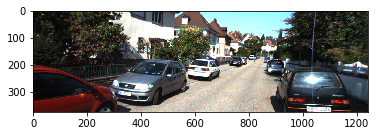

In [73]:
img = mpimg.imread(base_path + '/data_object_image_3/training/image_3/' +current_file+".png")
plt.imshow(img)

In [138]:


rot, tr, sc, image_translate_x, image_translate_y, ang, fliplr = get_augmentation_parameters(True)

data_reader_obj = DataReader(list_camera_paths[i_c],
                             list_calib_paths[i_c], 
                             list_label_paths[i_c], 
                             list_lidar_paths[i_c], 
                             rot, sc, tr, ang, image_translate_x, image_translate_y, 
                             get_actual_dims=True, 
                             fliplr=fliplr)
data_reader_obj.lidar_reader.size = (448//4, 512//4, 35)
# data_reader_obj.label_reader.size = (448//4, 512//4, 35)
camera_image = data_reader_obj.read_image()
lidar_image = data_reader_obj.lidar_reader.read_lidar()
_, label, directions = data_reader_obj.label_reader.read_label()


label2 = get_target(label, directions, anchors=np.array([3.9, 1.6, 1.5]))

(112, 128)
102.39095633675113 61.37205326414184 5.123127967853883 2.49148311366595 60.481394953703536
96.5088020645655 65.27596398128165 5.837182072195398 2.3802733617286282 -122.29220704629645
100.97857724593534 72.33550995028187 4.885109457939894 2.2852297904153187 61.627310953703535
87.18651814191435 71.16070442239479 5.805404574360426 2.538981710200233 58.18956295370353
60.52277655105155 87.60080797095054 6.472021526260091 2.586418693043301 -125.15699704629647
81.39520785593811 84.63403035646253 3.9178549996366896 2.5231130745114663 58.18956295370353



<Figure size 432x288 with 0 Axes>

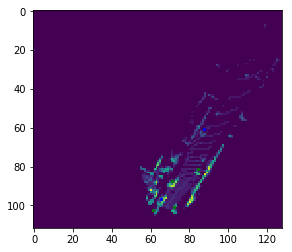

In [139]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 0:], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    plt.scatter(y, x, s=5, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, (-label[i][6]*57.2958))
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
#     ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


In [76]:
226.5721970389598 // 4, 276.6431893013815//4

(56.0, 69.0)

(112, 128)
105.70431658358704 60.18720495008357 5.122170620185981 2.491947981117854 73.911582
99.07731410738458 62.616628533326434 5.835993226146971 2.380757512199816 -108.86202
101.78704935611707 70.52244223801787 4.88423304476082 2.2856391100719464 75.05749800000001
88.64470631152163 66.17280804452477 5.804238367501733 2.5394910613635697 71.61975
58.89603198101372 75.96343208449392 6.470604074757617 2.586984537974699 -111.72681
79.88596833620221 77.93108160612746 3.9170679693249286 2.5236192422300547 71.61975



<Figure size 432x288 with 0 Axes>

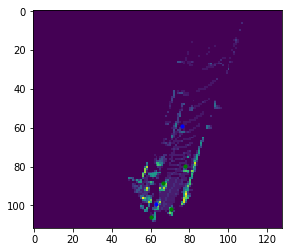

In [77]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 0:], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    plt.scatter(y, x, s=10, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, (-label[i][6]*57.2958))
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
#     ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


(112, 128)
105.70431658358704 60.18720495008357 5.122170620185981 2.491947981117854 73.911582
99.07731410738458 62.616628533326434 5.835993226146971 2.380757512199816 -108.86202
101.78704935611707 70.52244223801787 4.88423304476082 2.2856391100719464 75.05749800000001
88.64470631152163 66.17280804452477 5.804238367501733 2.5394910613635697 71.61975
58.89603198101372 75.96343208449392 6.470604074757617 2.586984537974699 -111.72681
79.88596833620221 77.93108160612746 3.9170679693249286 2.5236192422300547 71.61975



<Figure size 432x288 with 0 Axes>

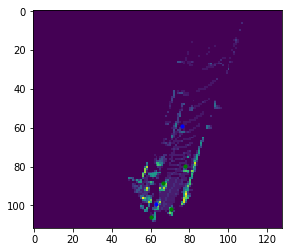

In [78]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 0:], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    plt.scatter(y, x, s=10, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, (-label[i][6]*57.2958))
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
#     ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


In [79]:
226.5721970389598//4, 276.6431893013815//4

(56.0, 69.0)

(112, 128)
105.70431658358704 60.18720495008357 5.122170620185981 2.491947981117854 73.911582
99.07731410738458 62.616628533326434 5.835993226146971 2.380757512199816 -108.86202
101.78704935611707 70.52244223801787 4.88423304476082 2.2856391100719464 75.05749800000001
88.64470631152163 66.17280804452477 5.804238367501733 2.5394910613635697 71.61975
58.89603198101372 75.96343208449392 6.470604074757617 2.586984537974699 -111.72681
79.88596833620221 77.93108160612746 3.9170679693249286 2.5236192422300547 71.61975



<Figure size 432x288 with 0 Axes>

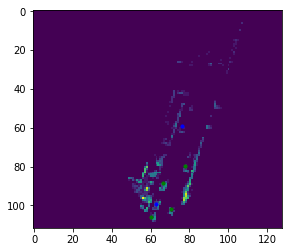

In [80]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 5:22], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    plt.scatter(y, x, s=10, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, (-label[i][6]*57.2958))
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
#     ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


(448, 512)
105.70431658358704 60.18720495008357 5.122170620185981 2.491947981117854 73.911582
99.07731410738458 62.616628533326434 5.835993226146971 2.380757512199816 -108.86202
101.78704935611707 70.52244223801787 4.88423304476082 2.2856391100719464 75.05749800000001
88.64470631152163 66.17280804452477 5.804238367501733 2.5394910613635697 71.61975
58.89603198101372 75.96343208449392 6.470604074757617 2.586984537974699 -111.72681
79.88596833620221 77.93108160612746 3.9170679693249286 2.5236192422300547 71.61975



<Figure size 432x288 with 0 Axes>

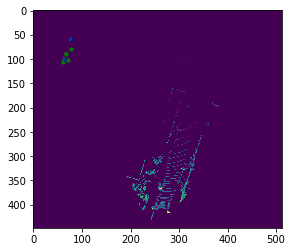

In [81]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(feed_dict[model.train_inputs_lidar][0, :, :, 0:1], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    plt.scatter(y, x, s=10, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, (-label[i][6]*57.2958))
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


60.18720495008357 27.666799516744174 105.70431658358704
62.616628533326434 26.525231109007592 99.07731410738458
70.52244223801787 27.112740923417938 101.78704935611707
66.17280804452477 25.115723711044506 88.64470631152163
75.96343208449392 23.844222901052873 58.89603198101372
77.93108160612746 27.258327043507414 79.88596833620221



<Figure size 432x288 with 0 Axes>

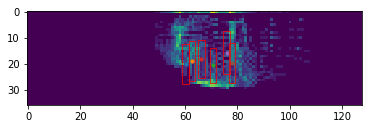

In [82]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
#     print(y, z)
    plt.scatter(y, z-h/2, s=10)
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
#     print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
print()

<Figure size 432x288 with 0 Axes>

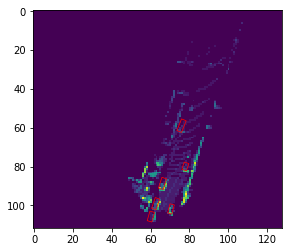

In [83]:
#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     plt.scatter(y, x, s=15)
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)



plt.show()


In [114]:
def convert_prediction_into_real_values2(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(448, 512), output_size=(112, 128), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    result = []
    ones_index = np.where(sigmoid(label_tensor[:, :,  -1])>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, -1]>=th)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
                        
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], :])
            anchor = np.array([x+0.5, y+0.5, 0.5, anchors[0], anchors[1], anchors[2]])

#             mins = np.array([-0.5, -0.5, -0.5, 0.7, 0.1, 0.1, -1.1, -1.1])
#             maxs = np.array([0.5, 0.5, 0.5, 1.9, 0.75, 0.91, 1.1, 1.1])
#             print(out[:3])
#             out[:8] = ((out[:8] + 1) / 2) * (maxs - mins) + mins

            out[3:6] = np.exp(out[3:6])
            print(out[:3])
            out[:3] = out[:3] + anchor[:3]
            print(out[:3])
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 35
            print(out[:3])

            result.append(out)
            print('---')
            
    return np.array(result)

[0.19511141 0.0405807  0.2969952 ]
[58.69511    75.54058     0.79699516]
[234.78044 302.16232  27.89483]
---
[-0.35753375  0.1798261   0.274447  ]
[79.14246    77.679825    0.77444696]
[316.56985  310.7193    27.105644]
---
[ 0.0332269  -0.4249997   0.34880894]
[88.533226   66.075       0.84880894]
[354.1329   264.3       29.708313]
---
[-0.5190583  -0.10326968  0.40997788]
[98.98094   62.39673    0.9099779]
[395.92377  249.58691   31.849228]
---
[-0.23993339  0.2538842   0.350619  ]
[101.26006     70.75388      0.85061896]
[405.04025  283.01553   29.771664]
---
[-0.10281865 -0.23639373  0.3450717 ]
[105.39718    60.263607    0.8450717]
[421.5887   241.05443   29.577509]
---
60.18720495008357 105.70431658358704 5.122170620185981 2.491947981117854 73.911582
62.616628533326434 99.07731410738458 5.835993226146971 2.380757512199816 -108.86202
70.52244223801787 101.78704935611707 4.88423304476082 2.2856391100719464 75.05749800000001
66.17280804452477 88.64470631152163 5.804238367501733 2.53

<Figure size 432x288 with 0 Axes>

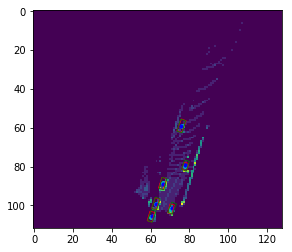

In [116]:
th=0.00001
truth_value = feed_dict[model.y_true][0, :, :, :]
# truth_value = None
converted_points = convert_prediction_into_real_values2(final_output[0, :, :, :], truth_value=truth_value, th=th)
# print(converted_points)
# converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
points = get_points(converted_points, list_calib_paths[i_c], th=th)
# print(points)
res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])


# if True:
#         print('-------------------')
#         labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
#         print(len(labels), len(points))
#         if len(labels) != len(points):
#             print('not the same')

#         points = np.array(points)
#         points = points[indxes]
#         if len(labels) > 0:
#             selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
#         else:
#             selected_idx = []
# #         print('done', len(selected_idx))
        
#         if len(selected_idx) > 0:
#             points = points[selected_idx]
#             res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
#         else:
#             res=""
 
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()


data_reader_obj.label_reader = LabelReader('./' + current_file + '.txt', 
                                           list_calib_paths[i_c],
                                           rot, tr, sc, ang, data_reader_obj.calib_reader,
                                        get_actual_dims=True, 
                                        from_file=True, fliplr=fliplr)
data_reader_obj.label_reader.size = (448//4, 512//4, 35)
_, label_bev, _ = data_reader_obj.read_label()
data_reader_obj.label_reader.get_actual_dims = False
_, label_bev2, _ = data_reader_obj.read_label()

plt.clf()
fig,ax = plt.subplots(1)

img = np.clip(np.mean(lidar_image[:, :, 18:], 2), 0, 1)
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
   
    plt.scatter(y, x, s=15, c='c')
    a = label[i][6]
   
    print(y, x, w, h, -a*57.2958)

    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    print(y, x, w, h, -label_bev[i][6]*57.2958)
    ax.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
        
#     if i == 2:
#         c = 'c'
#     else:
#         c = 'g'

    rect = patches.Polygon(l,linewidth=0.75,edgecolor=c,facecolor='none')
    ax.add_patch(rect)

print()


plt.show()


In [86]:
210.5539/4, 53.08090977357543*4

(52.638475, 212.3236390943017)

In [87]:
155.9943958035709/4, 155.9943958035709 // 4, 153.59128436452073/4, 153.59128436452073//4

(38.99859895089273, 38.0, 38.39782109113018, 38.0)

In [88]:
251.97153058214832//4, 251.97153058214832/4, 253.43287673793736//4, 253.43287673793736/4

(62.0, 62.99288264553708, 63.0, 63.35821918448434)

In [117]:
t3 = feed_dict[model.y_true][0, 36, 52, :8]
t3

array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [90]:
t2 = final_output[0, 36, 52, :8]
t2

array([-0.24959074,  0.12792023,  0.27289405,  1.5192454 ,  0.59109503,
        0.5857707 ,  0.81502414, -0.04015815], dtype=float32)

In [91]:
# mins = np.array([-0.5, -0.5, 0, 0.7, 0.1, 0.1, -1.1, -1.1])
# maxs = np.array([0.5, 0.5, 1, 1.9, 0.75, 0.91, 1.1, 1.1])
        
# t3 = ((t3 + 1) / 2) * (maxs - mins) + mins

# t2 = ((t2 + 1) / 2) * (maxs - mins) + mins


In [92]:
t3, t2

(array([0.   , 0.   , 0.5  , 1.3  , 0.425, 0.505, 0.   , 0.   ]),
 array([-0.12479538,  0.06396013,  0.63644701,  2.21154723,  0.61710587,
         0.74223714,  0.89652655, -0.04417397]))

In [93]:
(0.34829032 + 29.5) * 4, (0.34829032 + 29.5)

(119.39316128, 29.84829032)

In [94]:
(0.15265125 + 29.5) * 4, (0.15265125 + 29.5)

(118.610605, 29.65265125)

In [95]:
current_file

'000008'

In [96]:
276.6431893013815 / 4 - 276.6431893013815//4, 278.6925339791378/4 - 278.6925339791378//4

(0.16079732534537072, 0.6731334947844516)

In [97]:
80/512, 80/448, 3.5/35

(0.15625, 0.17857142857142858, 0.1)

In [98]:
t = np.where(feed_dict[model.y_true][0, :, :, -1] > 0)
t

(array([ 58,  79,  88,  99, 101, 105]), array([75, 77, 66, 62, 70, 60]))

In [118]:
t1 = np.where(final_output[0, :, :, -1] > 0)
t1

(array([ 99, 101]), array([62, 70]))

In [119]:
j = 0

In [120]:
for j in range(len(t[0])):
    print(np.mean(final_output[0, t[0][j], t[1][j], :8]))
    print(feed_dict[model.y_true][0, t[0][j], t[1][j], :3])
    print(final_output[0, t[0][j], t[1][j], :3])
    print(feed_dict[model.y_true][0, t[0][j], t[1][j], :3] - final_output[0, t[0][j], t[1][j], :3])
    print('---')

0.35928687
[0.39603198 0.46343207 0.1812635 ]
[0.19511141 0.0405807  0.2969952 ]
[ 0.20092057  0.42285138 -0.11573169]
---
0.2543012
[0.38596833 0.4310816  0.27880934]
[-0.35753375  0.1798261   0.274447  ]
[0.7435021  0.2512555  0.00436234]
---
0.23840214
[ 0.14470631 -0.32719195  0.2175921 ]
[ 0.0332269  -0.4249997   0.34880894]
[ 0.11147941  0.09780777 -0.13121684]
---
0.3726443
[-0.4226859   0.11662854  0.25786376]
[-0.5190583  -0.10326968  0.40997788]
[ 0.0963724   0.21989822 -0.15211412]
---
0.30030683
[0.28704935 0.02244224 0.27464974]
[-0.23993339  0.2538842   0.350619  ]
[ 0.5269827  -0.23144196 -0.07596925]
---
0.28553298
[ 0.20431659 -0.31279504  0.29048   ]
[-0.10281865 -0.23639373  0.3450717 ]
[ 0.30713522 -0.07640131 -0.05459172]
---


In [121]:
for j in range(len(t[0])):
    print(feed_dict[model.y_true][0, t[0][j], t[1][j], 3:6])
    print(final_output[0, t[0][j], t[1][j], 3:6])
    print(feed_dict[model.y_true][0, t[0][j], t[1][j], 3:6] - final_output[0, t[0][j], t[1][j], 3:6])
    print('---')

[1.4060969  0.48858002 0.53062826]
[1.4053963  0.5474593  0.41082233]
[ 0.00070059 -0.05887929  0.11980593]
---
[0.90421814 0.46373403 0.46373403]
[1.1871225  0.47422194 0.56038475]
[-0.28290433 -0.01048791 -0.09665072]
---
[1.2974632  0.47000363 0.3852624 ]
[1.3250821  0.4715358  0.43490112]
[-0.02761889 -0.00153217 -0.04963872]
---
[1.3029127 0.4054651 0.4510756]
[1.3416564  0.51487947 0.37559724]
[-0.03874373 -0.10941437  0.07547837]
---
[1.1249295  0.36464313 0.32930374]
[1.266351   0.51231897 0.52142954]
[-0.14142144 -0.14767584 -0.1921258 ]
---
[1.1724821  0.4510756  0.47000363]
[1.3263652  0.45346153 0.35536003]
[-0.1538831  -0.00238591  0.1146436 ]
---


In [103]:
mins = np.array([-0.5, -0.5, 0])
maxs = np.array([0.5, 0.5, 1])
        
t1 = ((feed_dict[model.y_true][0, t[0][j], t[1][j], :3]+ 1) / 2) * (maxs - mins) + mins
t2 =  ((final_output[0, t[0][j], t[1][j], :3]+ 1) / 2) * (maxs - mins) + mins
t1, t2

(array([ 0.10215831, -0.15639752,  0.64524001]),
 array([-0.05140933, -0.11819687,  0.67253584]))

In [104]:
for i in range(6):
    print((abs(feed_dict[model.y_true][0, t[0][j], t[1][j], i] - final_output[0, t[0][j], t[1][j], i])**2) * 0.5)
    print()
# print(sum((abs(feed_dict[model.y_true][0, t[0][j], t[1][j], :3] - final_output[0,t[0][j], t[1][j], :3])**2) * 0.5))

0.04716602301591166

0.002918579945723754

0.0014901276916550188

0.01184000416447617

2.8462935848239113e-06

0.0065715779189905454



In [105]:
current_file

'000008'

In [106]:
def convert_prediction_into_real_values3(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(448, 512), output_size=(112, 128), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    result = []
    ones_index = np.where(sigmoid(label_tensor[:, :,  -1])>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, -1]>=th)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
                        
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], :])
            anchor = np.array([x+0.5, y+0.5, 0.5, anchors[0], anchors[1], anchors[2]])

#             mins = np.array([-0.5, -0.5, -0.5, 0.7, 0.1, 0.1, -1.1, -1.1])
#             maxs = np.array([0.5, 0.5, 0.5, 1.9, 0.75, 0.91, 1.1, 1.1])
#             print(out[:3])
#             out[:8] = ((out[:8] + 1) / 2) * (maxs - mins) + mins

            out[3:6] = np.exp(out[3:6])
            print(out[:3])
            out[:3] = out[:3] + anchor[:3]
            print(out[:3])
#             out[:2] = out[:2] * ratio
            out[2] = out[2] * 35
            print(out[:3])

            result.append(out)
            print('---')
            
    return np.array(result)

In [107]:
def get_points2(converted_points, calib_path, 
                x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                size=(448//4, 512//4, 35), th=0.5):
    all_result = []
    for converted_points_ in converted_points:
        if sigmoid(converted_points_[-1]) >= th:
            result = [0] * 16
            result[0] = 'Car'
            result[1] = -1
            result[2] = -1
            result[3] = -10
            result[8] = converted_points_[5]
            result[9] = converted_points_[4]
            result[10] = converted_points_[3]
            result[14] = np.arctan2(converted_points_[6], converted_points_[7])
            result[15] = sigmoid(converted_points_[-1])

            calib_data = read_calib(calib_path)

            x_size = (x_range[1] - x_range[0])
            y_size = (y_range[1] - y_range[0])
            z_size = (z_range[1] - z_range[0])

            x_fac = (size[0]-1) / x_size
            y_fac = (size[1]-1) / y_size
            z_fac = (size[2]-1) / z_size          

            print(converted_points_[:3])
#             converted_points_[0] = 179.55859811597736
#             converted_points_[1] = 276.6431893013815
#             , 206.281385562958]
#             print(converted_points_[:3])
#             x, y = converted_points_[:2] / np.array([4., 4.])
            x, y, z = -((converted_points_[:3] - size) / np.array([x_fac, y_fac, z_fac])) - np.array([0, -1*y_range[0], -1*z_range[0]]) 
            point = np.array([[x, y, z]])
            print('point', point)
#             print(point)
            box3d_pts_3d = point

            pts_3d_ref = project_velo_to_ref(box3d_pts_3d, calib_data['Tr_velo_to_cam'].reshape((3, 4)))
#             print('pts_3d_ref')
#             print(pts_3d_ref)
            pts_3d_ref = project_ref_to_rect(pts_3d_ref, calib_data['R0_rect'].reshape((3, 3)))[0]
#             print('pts_3d_ref')
#             print(pts_3d_ref)
            for k in range(3):
                result[11 + k] = pts_3d_ref[k]

            imgbbox = ProjectTo2Dbbox(pts_3d_ref, converted_points_[5], converted_points_[4],
                         converted_points_[3], converted_points_[6], calib_data['P2'].reshape((3, 4)))

            result[4:8] = imgbbox
            all_result.append(result)
    return all_result

In [108]:

import numpy as np
import cv2
from data.data_utils.velodyne_points import *
import math
from utils.utils import *
import os
import tensorflow as tf
import matplotlib.patches as patches


from data.data_utils.fv_utils import *

class LabelReader2:

    def __init__(self, label_path, calib_path, rot, tr, sc, ang, calib_reader,
                    x_range=(0, 70), 
                    y_range=(-40, 40), 
                    z_range=(-2.5, 1), 
                    size=(448//4, 512//4, 35//1), 
                    get_actual_dims=False, 
                    from_file=True, fliplr=False):
        self.label_path = label_path
        self.calib_path = calib_path
        self.rot = rot
        self.tr = tr
        self.sc = sc
        self.x_range = x_range
        self.y_range = y_range
        self.z_range = z_range
        self.size = size
        self.get_actual_dims = get_actual_dims
        self.from_file = from_file
        self.ang = ang
        self.calib_reader = calib_reader
        self.fliplr = fliplr


    def read_label(self):

        """
        the file format is as follows: 
        type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
        dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
        rotation_y, score) 
        """
        if self.from_file:
            lines = []
            with open(self.label_path) as label_file:
                lines = label_file.readlines()
        else:
            lines = self.label_path.split('\n')

        # filter car class
        lines = list(map(lambda x: x.split(), lines))
        if len(lines) > 0:
           lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car']), lines))
        
        def get_parameter(index):
            return list(map(lambda x: x[index], lines))
        
        classes = np.array(get_parameter(0))
        dimension_height = np.array(get_parameter(8)).astype(float)
        dimension_width = np.array(get_parameter(9)).astype(float)
        dimension_length = np.array(get_parameter(10)).astype(float)
        location_x = np.array(get_parameter(11)).astype(float)
        location_y = np.array(get_parameter(12)).astype(float)
        location_z = np.array(get_parameter(13)).astype(float)
        angles = np.array(get_parameter(14)).astype(float)
        directions = np.array(angles>= 0).astype(float)
        
        calib_data = self.calib_reader.read_calib()

        locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])

        if len(locations) > 0 and len(locations[0]) > 0:
            locations = self.project_rect_to_velo2(self.rot, self.tr, self.sc, locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
       

        indx = []
        i = 0
        for point in locations:
            if (point[0] >= self.x_range[0]  and point[0] <= self.x_range[1])\
                and (point[1] >= self.y_range[0] and point[1] <= self.y_range[1])\
                and (point[2] >= self.z_range[0] and point[2] <= self.z_range[1]):
                indx.append(i)
            i += 1
        
       
        locations = np.array(list(filter(lambda point: (point[0] >= self.x_range[0]  and point[0] <= self.x_range[1])
                                        and (point[1] >= self.y_range[0] and point[1] <= self.y_range[1])
                                        and (point[2] >= self.z_range[0] and point[2] <= self.z_range[1]) , locations)))
        print(len(locations))
        if len(indx) > 0:
            dimension_height = dimension_height[indx]
            dimension_width = dimension_width[indx]
            dimension_length = dimension_length[indx]
            location_x = location_x[indx]
            location_y = location_y[indx]
            location_z = location_z[indx]
            angles = angles[indx]
            classes = classes[indx]
            directions = directions[indx]

        points = []
        sl = []
        sw = []
        sh = []
        for i in range(len(locations)):
            temp = self.project_point_from_camera_coor_to_velo_coor2(self.rot, self.tr, self.sc, [location_x[i], location_y[i], location_z[i]], 
                                                            [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                            angles[i],
                                                            calib_data)
                    
        
        
            points.append(temp[0])
            sl.append(temp[1])
            sw.append(temp[2])
            sh.append(temp[3])
        
        x_size = (self.x_range[1] - self.x_range[0])
        y_size = (self.y_range[1] - self.y_range[0])
        z_size = (self.z_range[1] - self.z_range[0])
                
        x_fac = (self.size[0]-1) / x_size
        y_fac = (self.size[1]-1) / y_size
        z_fac = (self.size[2]-1) / z_size

        if self.get_actual_dims:
            import math
            for i in range(len(points)):
                b = points[i]
                x0 = b[0][0]
                y0 = b[0][1]
                x1 = b[1][0]
                y1 = b[1][1]
                x2 = b[2][0]
                y2 = b[2][1]
                u0 = -(x0) * x_fac + self.size[0]
                v0 = -(y0 + self.size[2]) * y_fac + self.size[1]
                u1 = -(x1) * x_fac + self.size[0]
                v1 = -(y1 + self.size[2]) * y_fac + self.size[1]
                u2 = -(x2) * x_fac + self.size[0]
                v2 = -(y2 + self.size[2]) * y_fac + self.size[1]
                dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
                dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
                dimension_height[i] = math.sqrt((-(b[0][2]+(-1*self.z_range[1]))*z_fac-(-b[4][2]+self.z_range[1])*z_fac)**2)

        
        # for i in range(len(locations)):
        #     if angles[i] < 0:
        #         angles[i] += np.pi
        if self.get_actual_dims:
            output = [[-(locations[i][0] + -1*self.x_range[0]) * x_fac + self.size[0], -(locations[i][1] + -1*self.y_range[0]) * y_fac + self.size[1], -(locations[i][2] + -1*self.z_range[0]) * z_fac + self.size[2], 
                    dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
                    for i in range(len(locations))]
        else:
            output = [[-(locations[i][0] + -1*self.x_range[0]) * x_fac + self.size[0], -(locations[i][1] + -1*self.y_range[0]) * y_fac + self.size[1], -(locations[i][2] + -1*self.z_range[0]) * z_fac + self.size[2], 
                    dimension_length[i]*sl[i], dimension_width[i]*sw[i], dimension_height[i]*sh[i], angles[i]] 
                    for i in range(len(locations))]
       
        print('output')
        print(output)

        if self.ang != 0:
            for i in range(len(locations)):
              output[i][6] = output[i][6] - self.ang / (180/np.pi)
              if output[i][6] < -np.pi:
                  output[i][6] = output[i][6] + 2 * np.pi
              if output[i][6] > np.pi:
                  output[i][6] = output[i][6] - 2 * np.pi


        if self.fliplr:
            for i in range(len(locations)):
                h = self.size[1]
                output[i][1] = h - output[i][1]
                output[i][6] = ((-output[i][6]*(180/np.pi)) + 180) / (180/np.pi)
                if output[i][6] < -np.pi:
                  output[i][6] = output[i][6] + 2 * np.pi
                if output[i][6] > np.pi:
                  output[i][6] = output[i][6] - 2 * np.pi
        
#         output = list(filter(lambda point: 0 <= point[0] < self.size[0] and 0 <= point[1] < self.size[1] and 0 <= point[2] < self.size[2] , output))
        output = np.array(output)

        return points, output, directions


    def project_rect_to_velo2(self, rot, tr, sc, pts_3d_rect, RO, Tr_velo_to_cam):
        ''' Input: nx3 points in rect camera coord.
            Output: nx3 points in velodyne coord.
        ''' 
        pts_3d_ref = self.project_rect_to_ref(pts_3d_rect, RO)
        temp = self.project_ref_to_velo(pts_3d_ref, Tr_velo_to_cam)
        temp = temp.transpose() + tr[:3, :1]
        temp = np.dot(sc[:3, :3], np.dot(rot[:3, :3], temp)).transpose()
        return temp

    def project_rect_to_ref(self, pts_3d_rect, R0):
        ''' Input and Output are nx3 points '''
        return np.transpose(np.dot(np.linalg.inv(R0.reshape((3, 3))), np.transpose(pts_3d_rect)))
    
    def project_ref_to_velo(self, pts_3d_ref, Tr_velo_to_cam):
        pts_3d_ref = self.cart2hom(pts_3d_ref) # nx4
        C2V = self.inverse_rigid_trans(Tr_velo_to_cam.reshape((3, 4)))
        return np.dot(pts_3d_ref, np.transpose(C2V))

    def cart2hom(self, pts_3d):
        ''' Input: nx3 points in Cartesian
            Oupput: nx4 points in Homogeneous by pending 1
        '''
        n = pts_3d.shape[0]
        pts_3d_hom = np.hstack((pts_3d, np.ones((n,1))))
        return pts_3d_hom

    def inverse_rigid_trans(self, Tr):
        ''' Inverse a rigid body transform matrix (3x4 as [R|t])
            [R'|-R't; 0|1]
        '''
        inv_Tr = np.zeros_like(Tr) # 3x4
        inv_Tr[0:3,0:3] = np.transpose(Tr[0:3,0:3])
        inv_Tr[0:3,3] = np.dot(-np.transpose(Tr[0:3,0:3]), Tr[0:3,3])
        return inv_Tr


    def project_point_from_camera_coor_to_velo_coor2(self, rot, tr, sc, location, dimemsion, agnle, calib_data):
        R = roty(agnle)
        h, w, l = dimemsion
        x, y, z = location
        x_corners = [l/2,l/2,-l/2,-l/2,l/2,l/2,-l/2,-l/2];
        y_corners = [0,0,0,0,-h,-h,-h,-h];
        z_corners = [w/2,-w/2,-w/2,w/2,w/2,-w/2,-w/2,w/2];
        
        # rotate and translate 3d bounding box
        corners_3d = np.dot(R, np.vstack([x_corners,y_corners,z_corners]))
        #print corners_3d.shape
        corners_3d[0,:] = corners_3d[0,:] + x;
        corners_3d[1,:] = corners_3d[1,:] + y;
        corners_3d[2,:] = corners_3d[2,:] + z;

        box3d_pts_3d = np.transpose(corners_3d)

        pts_3d_ref = project_rect_to_ref(box3d_pts_3d, calib_data['R0_rect'])
        result = project_ref_to_velo(pts_3d_ref, calib_data['Tr_velo_to_cam'])
        
        temp = result
        
        
        x_size = (self.x_range[1] - self.x_range[0])
        y_size = (self.y_range[1] - self.y_range[0])
        z_size = (self.z_range[1] - self.z_range[0])
                
        x_fac = (self.size[0]-1) / x_size
        y_fac = (self.size[1]-1) / y_size
        z_fac = (self.size[2]-1) / z_size
        
        b = temp
        x0 = b[0][0]
        y0 = b[0][1]
        x1 = b[1][0]
        y1 = b[1][1]
        x2 = b[2][0]
        y2 = b[2][1]
        u0 = -(x0) * x_fac + self.size[0]
        v0 = -(y0 + self.size[2]) * y_fac + self.size[1]
        u1 = -(x1) * x_fac + self.size[0]
        v1 = -(y1 + self.size[2]) * y_fac + self.size[1]
        u2 = -(x2) * x_fac + self.size[0]
        v2 = -(y2 + self.size[2]) * y_fac + self.size[1]
        dimension_length = math.sqrt((v1-v2)**2 + (u1-u2)**2)
        dimension_width = math.sqrt((v1-v0)**2 + (u1-u0)**2)
        dimension_height = math.sqrt((-(b[0][2]+(-1*self.z_range[1]))*z_fac-(-b[4][2]+self.z_range[1])*z_fac)**2)
        
        temp = temp.transpose() + tr[:3, :1]
        temp = np.dot(sc[:3, :3], np.dot(rot[:3, :3], temp)).transpose()
        
        b = temp
        x0 = b[0][0]
        y0 = b[0][1]
        x1 = b[1][0]
        y1 = b[1][1]
        x2 = b[2][0]
        y2 = b[2][1]
        u0 = -(x0) * x_fac + self.size[0]
        v0 = -(y0 + self.size[2]) * y_fac + self.size[1]
        u1 = -(x1) * x_fac + self.size[0]
        v1 = -(y1 + self.size[2]) * y_fac + self.size[1]
        u2 = -(x2) * x_fac + self.size[0]
        v2 = -(y2 + self.size[2]) * y_fac + self.size[1]
        dimension_length2 = math.sqrt((v1-v2)**2 + (u1-u2)**2)
        dimension_width2 = math.sqrt((v1-v0)**2 + (u1-u0)**2)
        dimension_height2 = math.sqrt((-(b[0][2]+(-1*self.z_range[1]))*z_fac-(-b[4][2]+self.z_range[1])*z_fac)**2)
        
                
        return temp, dimension_length2/dimension_length, dimension_width2/dimension_width, dimension_height2/dimension_height
    

[0.05132961 0.30406785 0.35627493]
[88.55133    65.80407     0.85627496]
[88.55133  65.80407  29.969624]
---
[ 0.0332269  -0.4249997   0.34880894]
[88.533226   66.075       0.84880894]
[88.533226 66.075    29.708313]
---
[ 0.13271768 -0.10727404  0.3637324 ]
[98.63272   62.392727   0.8637324]
[98.63272  62.392727 30.230635]
---
[-0.5190583  -0.10326968  0.40997788]
[98.98094   62.39673    0.9099779]
[98.98094  62.39673  31.849228]
---
[-0.23993339  0.2538842   0.350619  ]
[101.26006     70.75388      0.85061896]
[101.26006   70.75388   29.771664]
---
[88.55133  65.80407  29.969624]
point [[14.78744919 -0.82146111 -1.98216713]]
[88.533226 66.075    29.708313]
point [[14.79886648 -0.99212406 -1.95526751]]
[98.63272  62.392727 30.230635]
point [[ 8.42981562  1.32741613 -2.00903592]]
[98.98094  62.39673  31.849228]
point [[ 8.2102169   1.32489542 -2.17565581]]
[101.26006   70.75388   29.771664]
point [[ 6.77293314 -3.93945409 -1.96178891]]
5
4
60.18720495008357 105.70431658358704 5.1221706

<Figure size 432x288 with 0 Axes>

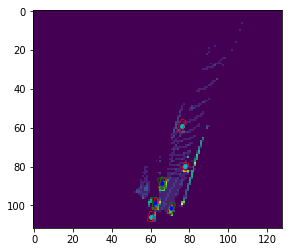

In [110]:
th=0.4
# truth_value = feed_dict[model.y_true][0, :, :, :, :]
truth_value = None
converted_points = convert_prediction_into_real_values3(final_output[0, :, :,  :], truth_value=truth_value, th=th)
# converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
points = get_points2(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
# print('res', res)
print(len(points))
if True:
        labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
#         print(len(labels), len(points))
        if len(labels) != len(points):
            print('not the same')

        points = np.array(points)
        points = points[indxes]
        if len(labels) > 0:
            selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
        else:
            selected_idx = []
#         print('done', len(selected_idx))
        
        if len(selected_idx) > 0:
            points = points[selected_idx]
            print(len(points))
            res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
        else:
            res=""
            
   
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

# all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label(rot, tr, sc, './'+ current_file + '.txt', 
#                                                   base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
#                                                   0, 0, get_actual_dims=True)

data_reader_obj.label_reader = LabelReader('./' + current_file + '.txt', 
                                           list_calib_paths[i_c],
                                           rot, tr, sc, ang, data_reader_obj.calib_reader,
                                        get_actual_dims=True, 
                                        from_file=True, fliplr=fliplr)

data_reader_obj.label_reader.size = (448//4, 512//4, 35)
points, label_bev, directions = data_reader_obj.read_label()

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 18:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
   
    plt.scatter(y, x, s=15, c='c')
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
    
    print(y, x, w, h, -a*57.2958)
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
#     if i == 1:
#         break
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
#     if i in [3, 4]:
#         y = 52.638474
#         x = 36.260956
    print(y, x, w, h, -label_bev[i][6]*57.2958)
    ax.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
#     break

print()


plt.show()


In [217]:
current_file

'000008'

In [435]:
145.04382/4

36.260955

In [399]:
253.43287673793736//4, 251.97153058214832//4

(63.0, 62.0)

In [356]:
226.5721970389598//4

56.0

155.9943958035709 26.900505029407775 201.83263683726105
154.82973045642188 26.25124613672834 119.39316118852918

156.78433834845112 26.389831504627985 121.0110865421957
157.81505424643808 26.86314556839347 203.68816460376897
157.8702758007849 27.27049422184568 204.38178344012192


<Figure size 432x288 with 0 Axes>

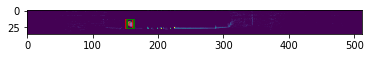

In [357]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
#     print(y, z)
    plt.scatter(y, z-h/2, s=10)
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
#     print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
print()
for i in range(0, len(label_bev)):
    l = label_bev[i][3]
    w = label_bev[i][4] 
    h = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]
#     print(y, z)
    plt.scatter(y, z-h/2, s=10)
    a = label_bev[i][6]
#     if a < 0:
#       a = a + 3.14
#     print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle= 0,linewidth=0.75,edgecolor='g',facecolor='none')

    ax.add_patch(rect)
    
plt.show()


In [276]:
current_file

'000001'

169
not the same
150.72534611124524 72.64256549335948 23.561998529779174 11.943959131051713 -89.954406




<Figure size 432x288 with 0 Axes>

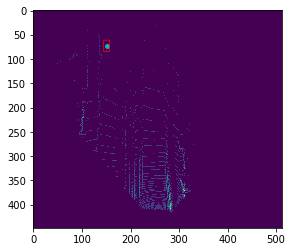

In [283]:
th=0.01
# truth_value = feed_dict[model.y_true][0, :, :, :, :]
truth_value = None
converted_points = convert_prediction_into_real_values(final_output[0, :, :,  :], truth_value=truth_value, th=th)
# converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
# print('res', res)
print(len(points))
if True:
        labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
#         print(len(labels), len(points))
        if len(labels) != len(points):
            print('not the same')

        points = np.array(points)
        points = points[indxes]
        if len(labels) > 0:
            selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
        else:
            selected_idx = []
#         print('done', len(selected_idx))
        
        if len(selected_idx) > 0:
            points = points[selected_idx]
            print(len(points))
            res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
        else:
            res=""
            
   
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label(rot, tr, sc, './'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 18:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
   
    plt.scatter(y, x, s=15, c='c')
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
    
    print(y, x, w, h, -a*57.2958)
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
#     if i == 1:
#         break
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    print(y, x, w, h, -label_bev[i][6]*57.2958)
    ax.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
#     break

print()


plt.show()


In [284]:
226.5721970389598 // 4 - 226.5721970389598/4, 225.08346074265836//4 - 225.08346074265836/4

(-0.6430492597399535, -0.27086518566459006)

150.72534611124524 26.996508451042416 72.64256549335948



<Figure size 432x288 with 0 Axes>

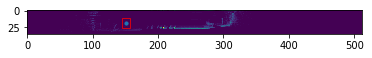

In [285]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
#     print(y, z)
    plt.scatter(y, z-h/2, s=10)
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
#     print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
print()
for i in range(0, len(label_bev)):
    l = label_bev[i][3]
    w = label_bev[i][4] 
    h = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]
#     print(y, z)
    plt.scatter(y, z-h/2, s=10)
    a = label_bev[i][6]
#     if a < 0:
#       a = a + 3.14
#     print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle= 0,linewidth=0.75,edgecolor='g',facecolor='none')

    ax.add_patch(rect)
    
plt.show()


### Visualization

In [286]:
i = 2
j = 5
np.mean(final_output[0, :, :, j])

-0.27774826

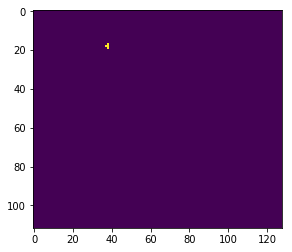

In [290]:
plt.imshow(sigmoid(final_output[0, :, :, -1])>=0.2)

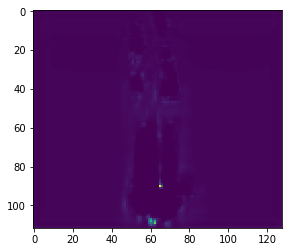

In [178]:
plt.imshow(sigmoid(final_output[0, :, :, -1]))

In [46]:
debug_layers.keys()

dict_keys(['fpn_lidar2_output_post_conv_1_1', 'fpn_lidar2_output_post_conv_1_0', 'fpn_lidar1_output_post_conv_1_1', 'final_layer', 'fpn_lidar1_output_post_conv_1_0'])

In [47]:
debug_layers['fpn_lidar1_output_post_conv_1_1'].shape

(1, 112, 128, 128)

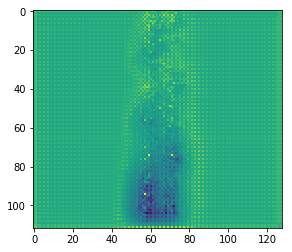

In [40]:
i = 50
plt.imshow(debug_layers['fpn_lidar1_output_post_conv_1_0'][0, :, :, i])

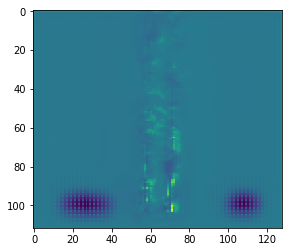

In [65]:
i = 50
plt.imshow(debug_layers['fpn_lidar1_output_post_conv_1_0'][0, :, :, i])

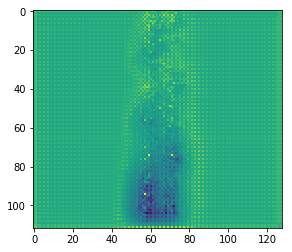

In [41]:
i = 50
plt.imshow(debug_layers['fpn_lidar1_output_post_conv_1_0'][0, :, :, i])

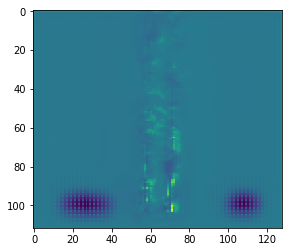

In [66]:
i = 50
plt.imshow(debug_layers['fpn_lidar1_output_post_conv_1_0'][0, :, :, i])

In [50]:
cnn_lidar_resgroups[0].shape

(1, 224, 256, 64)

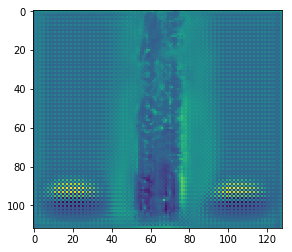

In [51]:
i = 3
j = 33
plt.imshow(cnn_lidar_resgroups[i][0, :, :, j])

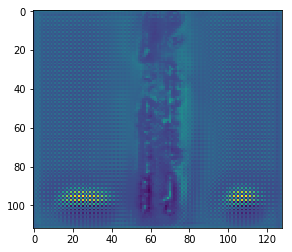

In [67]:
i = 3
j = 33
plt.imshow(cnn_lidar_resgroups[i][0, :, :, j])